In [47]:
import numpy as np
import matplotlib.pyplot as plt
import celerite
from celerite import terms
from celerite.modeling import Model, ConstantModel
import muhz2days
import autocorr
from scipy.ndimage.filters import gaussian_filter
from astropy.stats import LombScargle

In [48]:
del pool

In [3]:
from multiprocessing import Pool
pool = Pool()

Process ForkPoolWorker-2:
Process ForkPoolWorker-4:
Process ForkPoolWorker-5:
Process ForkPoolWorker-3:
Process ForkPoolWorker-1:
Process ForkPoolWorker-7:
Process ForkPoolWorker-8:
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Process ForkPoolWorker-6:
  File "/Users/samuelgrunblatt/anaconda3/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/Users/samuelgrunblatt/anaconda3/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
Traceback (most recent call last):
  File "/Users/samuelgrunblatt/anaconda3/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
Traceback (most recent call last):
  File "/Users/samuelgrunblatt/anaconda3/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/Users/samuelgrunblatt/anaconda3/lib/python3.6/

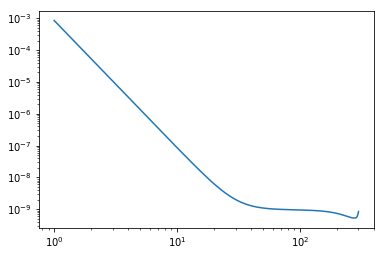

In [49]:
muhzconv = 1e6 / (3600*24)

def muhz2idays(muhz):
    return muhz / muhzconv

def muhz2omega(muhz):
    return muhz2idays(muhz) * 2.0 * np.pi

def idays2muhz(idays):
    return idays * muhzconv

def omega2muhz(omega):
    return idays2muhz(omega / (2.0 * np.pi))

omega = np.linspace(1, 300, 1000)
freqmuhz = omega2muhz(omega)
freqidays = muhz2idays(freqmuhz)
plt.loglog(omega, kernel.get_psd(omega));

/Users/samuelgrunblatt/Desktop/quicklook/234594397.dat.ts


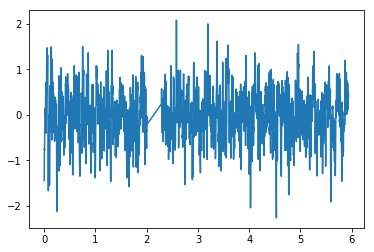

In [50]:
#data = np.loadtxt('/Users/samuelgrunblatt/Desktop/quicklook/211351816.dat.ts')
#data = np.loadtxt('/Users/samuelgrunblatt/Desktop/asterointimedom/kplr1162746_llc_concat.dat') # Using Guy's star
#log_numax = np.log(25)
#log_dnu = np.log(3.0)

import glob
datalist = []
#for name in glob.glob('/Users/samuelgrunblatt/Desktop/guysstars/20Stars/Data/*.dat'): #Using one of Guy's stars!
for name in glob.glob('/Users/samuelgrunblatt/Desktop/quicklook/*.dat.ts'): 
    datalist.append(name)
#print(datalist)
print(datalist[500])

data = np.loadtxt(datalist[500])

t = np.array(data[:, 0]*0.0864)[:3000]
y = np.array(data[:, 1:2]*1e3)[:3000]

log_var = np.log(np.var(data[:,1]*1e3))

df = 0.01 / (np.max(t) - np.min(t))
freq = np.arange(10.0, 0.5 / np.median(np.diff(t)), df)
len(freq)

plt.plot(t, y[:,0])

model = LombScargle(t, y[:,0])
power = model.power(freq)

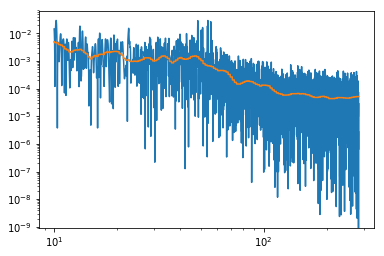

In [51]:
def estimate_background(x, y, log_width=0.02):
    count = np.zeros(len(x), dtype=int)
    bkg = np.zeros_like(x)
    x0 = np.log10(x[0])
    while x0 < np.log10(x[-1]):
        m = np.abs(np.log10(x) - x0) < log_width
        bkg[m] += np.median(y[m])
        count[m] += 1
        x0 += 0.5 * log_width
    return bkg / count

bkg = estimate_background(freq, power)
plt.loglog(freq, power)
plt.plot(freq, bkg)

In [52]:
df = freq[1] - freq[0]
smoothed_ps = gaussian_filter(power / bkg, 5 / df)

# And the autocorrelation function of a lightly smoothed power spectrum
acor_func = autocorr.function_1d(gaussian_filter(power / bkg, 0.5 / df))
lags = df*np.arange(len(acor_func))
acor_func = acor_func[lags < 30]
lags = lags[lags < 30]

# Find the peaks
def find_peaks(z):
    peak_inds = (z[1:-1] > z[:-2]) * (z[1:-1] > z[2:])
    peak_inds = np.arange(1, len(z)-1)[peak_inds]
    peak_inds = peak_inds[np.argsort(z[peak_inds])][::-1]
    return peak_inds

peak_freqs = freq[find_peaks(smoothed_ps)]
nu_max = peak_freqs[peak_freqs > 5][0]

# Expected delta_nu: Stello et al (2009)
dnu_expected = 0.263 * nu_max ** 0.772
peak_lags = lags[find_peaks(acor_func)]
delta_nu = peak_lags[np.argmin(np.abs(peak_lags - dnu_expected))]
print("nu_max = {0}, delta_nu = {1}".format(nu_max, delta_nu))

log_numax = np.log(nu_max)
log_dnu = np.log(delta_nu)

nu_max = 53.88416995265732, delta_nu = 5.6260028209607515


In [53]:
class ASTerm(terms.SHOTerm):
    parameter_names = ("log_numax", "log_dnu", "gamma_0", "gamma_1", "log_H0", "log_H1", "log_sigma", "log_Q")
    def get_all_coefficients(self, params=None):
        if params is None:
            params = self.get_parameter_vector(include_frozen=True)
        log_numax, log_dnu, gamma_0, gamma_1, log_H0, log_H1, log_sigma, log_Q = params
        gamma = np.array([gamma_0, gamma_1])
        H = np.exp([log_H0, log_H1])
        nunl, ampnl = self.modelfreq(np.exp(log_numax), np.exp(log_dnu), gamma, H, np.exp(log_sigma))
        coeffs = []
        for j in range(nunl.size):
            nu, amp = nunl.flat[j], ampnl.flat[j]
            log_S0 = np.log(amp)-2*log_Q
            log_omega = np.log(2*np.pi*nu)
            coeffs.append(super(ASTerm,self).get_all_coefficients([log_S0, log_Q, log_omega]))
        return [np.concatenate(args) for args in zip(*coeffs)]
        
    def modelfreq(self, numax, dnu, gammas, Hs, sigma):
        nprime = np.arange(-2,3,1)
        l = np.arange(len(gammas))
        nunl= numax + gammas[None,:] + (dnu * (nprime[:,None] + l[None,:]/2.))
        Anl = Hs[None,:]*np.exp(-(nunl - numax)**2/(2*sigma**2))
        return nunl, Anl

In [54]:
log_var = np.log(np.var(data[:, 1]))
k1 = ASTerm(
    log_numax=log_numax,
    log_dnu=log_dnu,
    gamma_0=0.0,
    gamma_1=0.0,
    log_H0=log_var,
    log_H1=log_var,
    log_sigma=np.log(10.0),
    log_Q=8.
)

k1.freeze_all_parameters()

k2 = terms.SHOTerm(log_Q=-0.5*np.log(2), log_S0=log_var, log_omega0=np.log(100))
k2.freeze_parameter("log_Q")

k3 = terms.SHOTerm(log_Q=-0.5*np.log(2), log_S0=log_var, log_omega0=np.log(150))
k3.freeze_parameter("log_Q")

k4 = terms.JitterTerm(0.5*log_var)

kernel = k1 + k2 + k3 + k4

In [55]:
kernel.coefficients

[array([], dtype=float64),
 array([], dtype=float64),
 array([1.40664491e-08, 1.97794617e-08, 2.55983312e-08, 3.05045807e-08,
        3.34836870e-08, 3.38649670e-08, 3.15669079e-08, 2.71254118e-08,
        2.14916299e-08, 1.57031218e-08, 2.08464959e-05, 3.12697439e-05]),
 array([2.35938402e-12, 3.31763514e-12, 4.29364179e-12, 5.11657347e-12,
        5.61626289e-12, 5.68021550e-12, 5.29475901e-12, 4.54978103e-12,
        3.60481938e-12, 2.63390529e-12, 2.08464959e-05, 3.12697439e-05]),
 array([4.49294807e-02, 4.78940661e-02, 5.08586515e-02, 5.38232369e-02,
        5.67878223e-02, 5.97524077e-02, 6.27169931e-02, 6.56815785e-02,
        6.86461640e-02, 7.16107494e-02, 7.07106781e+01, 1.06066017e+02]),
 array([267.86578464, 285.54039353, 303.21500241, 320.88961129,
        338.56422017, 356.23882906, 373.91343794, 391.58804682,
        409.2626557 , 426.93726459,  70.71067812, 106.06601718])]

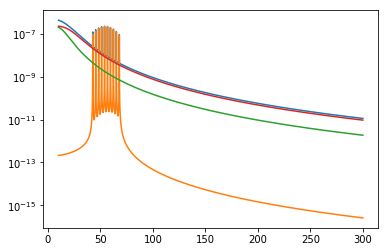

In [56]:
freq_muHz = np.linspace(10, 300, 10000)
plt.semilogy(freq_muHz, kernel.get_psd(2*np.pi*freq_muHz))
for term in kernel.terms:
    plt.semilogy(freq_muHz, term.get_psd(2*np.pi*freq_muHz))

In [57]:
time,flux = sorted(np.array(data[:,0])*0.0864)[:2000], np.array(data[:,1])[:2000]

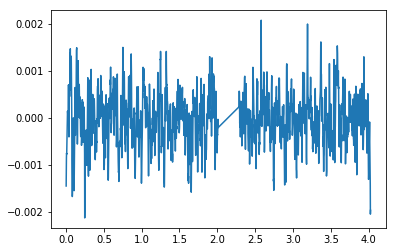

In [58]:
plt.plot(time,flux)

In [59]:
gp = celerite.GP(kernel)
gp.compute(time)

In [60]:
def nll(params):
    gp.set_parameter_vector(params)
    return -gp.log_likelihood(flux)

In [61]:
from scipy.optimize import minimize

soln = minimize(nll, gp.get_parameter_vector())
gp.set_parameter_vector(soln.x)
soln

      fun: -13730.799612385545
 hess_inv: array([[ 3.60912663e-05, -2.21258435e-06,  1.45215528e-05,
         1.77209568e-05, -9.50813318e-05],
       [-2.21258435e-06,  6.05758701e-06, -8.74650153e-06,
        -1.38339825e-05,  3.26034840e-06],
       [ 1.45215528e-05, -8.74650153e-06,  1.96383508e-05,
         1.90828699e-05, -3.74293154e-05],
       [ 1.77209568e-05, -1.38339825e-05,  1.90828699e-05,
         4.75718063e-05, -3.94331666e-05],
       [-9.50813318e-05,  3.26034840e-06, -3.74293154e-05,
        -3.94331666e-05,  2.54612107e-04]])
      jac: array([0.00366211, 0.00732422, 0.00366211, 0.00488281, 0.00463867])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 1006
      nit: 59
     njev: 142
   status: 2
  success: False
        x: array([-20.55509983,   5.58823129, -20.89183278,   4.41328467,
        -9.09890798])

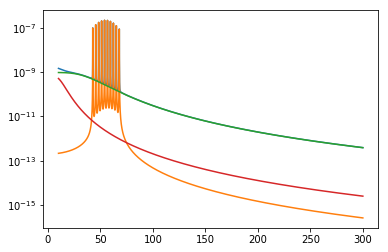

In [62]:
plt.semilogy(freq_muHz, kernel.get_psd(2*np.pi*freq_muHz))
for term in kernel.terms:
    plt.semilogy(freq_muHz, term.get_psd(2*np.pi*freq_muHz))

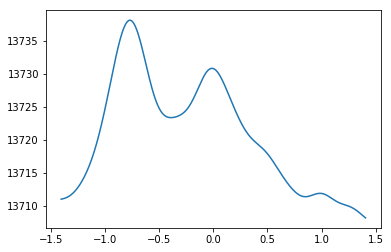

In [63]:
gammagrid = np.linspace(-0.25*np.exp(log_dnu),0.25*np.exp(log_dnu), 500)
like = np.empty_like(gammagrid)
for i,gamma in enumerate(gammagrid):
    k1.set_parameter("gamma_1", gamma)
    like[i] = gp.log_likelihood(flux)
best = gammagrid[np.argmax(like)]
k1.set_parameter("gamma_1", best)
plt.plot(gammagrid,like)

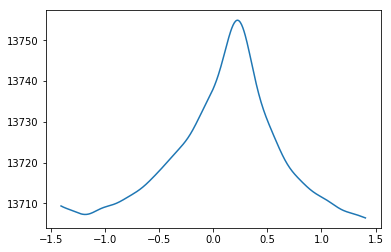

In [64]:
gammagrid = np.linspace(-0.25*np.exp(log_dnu),0.25*np.exp(log_dnu), 500)
like = np.empty_like(gammagrid)
for i,gamma in enumerate(gammagrid):
    k1.set_parameter("gamma_0", gamma)
    like[i] = gp.log_likelihood(flux)
best = gammagrid[np.argmax(like)]
k1.set_parameter("gamma_0", best)
plt.plot(gammagrid,like)

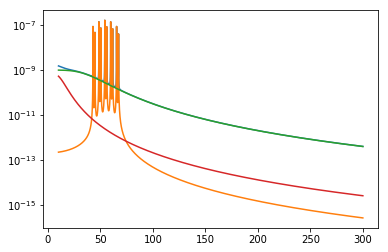

In [65]:
plt.semilogy(freq_muHz, kernel.get_psd(2*np.pi*freq_muHz))
for term in kernel.terms:
    plt.semilogy(freq_muHz, term.get_psd(2*np.pi*freq_muHz))

In [66]:
k1.thaw_parameter("gamma_0")
k1.thaw_parameter("gamma_1")
soln = minimize(nll, gp.get_parameter_vector())
gp.set_parameter_vector(soln.x)
soln

      fun: -13755.463283709261
 hess_inv: array([[ 6.77378789e-04,  1.48095455e-04,  4.28261542e-03,
        -1.13067226e-03, -1.82794899e-02,  5.26490163e-03,
         2.45423008e-04],
       [ 1.48095455e-04,  2.54562912e-03,  2.69353129e-02,
        -7.18490075e-03, -1.15908266e-01,  3.40442697e-02,
         1.62136446e-03],
       [ 4.28261542e-03,  2.69353129e-02,  7.06751606e-01,
        -1.88015621e-01, -2.89089556e+00,  8.25176482e-01,
         4.10400046e-02],
       [-1.13067226e-03, -7.18490075e-03, -1.88015621e-01,
         5.05243309e-02,  7.68294212e-01, -2.19780733e-01,
        -1.12722936e-02],
       [-1.82794899e-02, -1.15908266e-01, -2.89089556e+00,
         7.68294212e-01,  1.22152790e+01, -3.64610178e+00,
        -1.71948603e-01],
       [ 5.26490163e-03,  3.40442697e-02,  8.25176482e-01,
        -2.19780733e-01, -3.64610178e+00,  1.15870415e+00,
         5.01629890e-02],
       [ 2.45423008e-04,  1.62136446e-03,  4.10400046e-02,
        -1.12722936e-02, -1.7194860

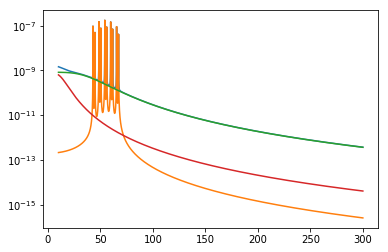

In [67]:
plt.semilogy(freq_muHz, kernel.get_psd(2*np.pi*freq_muHz))
for term in kernel.terms:
    plt.semilogy(freq_muHz, term.get_psd(2*np.pi*freq_muHz))

In [68]:
k1.thaw_parameter("log_H0")
k1.thaw_parameter("log_H1")
soln = minimize(nll, gp.get_parameter_vector())
gp.set_parameter_vector(soln.x)
soln

      fun: -13770.087747874517
 hess_inv: array([[ 4.42496419e-04, -1.65051465e-06, -1.98716665e-04,
        -9.34385625e-05,  8.72806521e-05,  1.26686903e-06,
         9.44392806e-05, -5.42911866e-04, -1.70301850e-05],
       [-1.65051465e-06,  9.27852795e-04,  1.11530436e-04,
         2.55836642e-04,  1.41840552e-04, -4.86214708e-05,
        -6.75563900e-04, -4.30712900e-04,  4.69517994e-05],
       [-1.98716665e-04,  1.11530436e-04,  1.32772470e-03,
         1.38924890e-03, -8.77680975e-04,  2.36915681e-04,
        -3.46982354e-04, -1.02239247e-04, -9.01260153e-05],
       [-9.34385625e-05,  2.55836642e-04,  1.38924890e-03,
         1.97036822e-03, -9.04181714e-04,  3.01005395e-04,
        -6.15623816e-04, -1.41933581e-03, -3.17601706e-04],
       [ 8.72806521e-05,  1.41840552e-04, -8.77680975e-04,
        -9.04181714e-04,  1.04563839e-03,  1.23981354e-04,
        -2.64188416e-04,  6.05734618e-05, -2.77628914e-04],
       [ 1.26686903e-06, -4.86214708e-05,  2.36915681e-04,
         

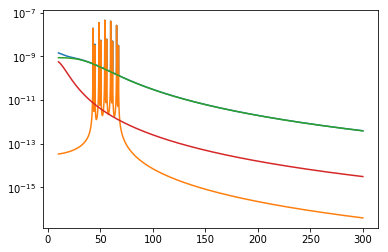

In [69]:
plt.semilogy(freq_muHz, kernel.get_psd(2*np.pi*freq_muHz))
for term in kernel.terms:
    plt.semilogy(freq_muHz, term.get_psd(2*np.pi*freq_muHz))

      fun: -13770.595811330299
 hess_inv: array([[ 4.13507967e-04, -1.01309547e-05,  1.41593867e-04,
         2.03784762e-03,  1.69551286e-03,  7.06171625e-05,
         7.49843457e-06,  4.07884289e-05, -1.72112494e-04,
        -1.84729277e-05],
       [-1.01309547e-05,  7.72615158e-04, -1.47254740e-03,
         1.36809750e-03, -1.44945851e-03, -2.22762267e-04,
         2.82204552e-05,  6.39741055e-04, -2.47007865e-05,
         3.31833340e-05],
       [ 1.41593867e-04, -1.47254740e-03,  3.95260312e-01,
         2.43466349e-01,  2.20405182e-01,  4.53187812e-03,
        -1.61405776e-04, -1.33194363e-02, -1.52460742e-02,
        -6.90991008e-04],
       [ 2.03784762e-03,  1.36809750e-03,  2.43466349e-01,
         5.41357171e-01,  2.38989888e-01,  8.97873674e-04,
         1.13536278e-03,  6.31561646e-03, -1.37132848e-02,
        -1.30451385e-03],
       [ 1.69551286e-03, -1.44945851e-03,  2.20405182e-01,
         2.38989888e-01,  2.30065460e-01,  6.01682378e-03,
         2.46889610e-04, -1.

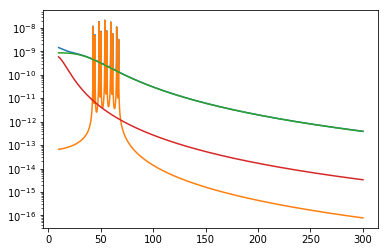

In [70]:
k1.thaw_parameter("log_Q")
soln = minimize(nll, gp.get_parameter_vector())
gp.set_parameter_vector(soln.x)
print(soln)

plt.semilogy(freq_muHz, kernel.get_psd(2*np.pi*freq_muHz))
for term in kernel.terms:
    plt.semilogy(freq_muHz, term.get_psd(2*np.pi*freq_muHz))

In [71]:
# k1.thaw_parameter("log_sigma")
# soln = minimize(nll, gp.get_parameter_vector())
# gp.set_parameter_vector(soln.x)
# print(soln)

# plt.semilogy(freq_muHz, kernel.get_psd(2*np.pi*freq_muHz))
# for term in kernel.terms:
#     plt.semilogy(freq_muHz, term.get_psd(2*np.pi*freq_muHz))

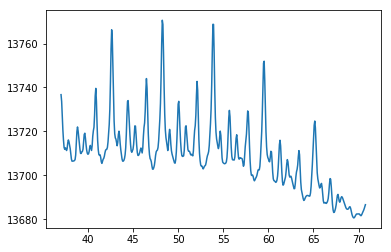

In [72]:
numaxgrid = np.linspace(-3*np.exp(log_dnu),3*np.exp(log_dnu), 500)+np.exp(log_numax)
like = np.empty_like(numaxgrid)
for i,numax in enumerate(numaxgrid):
    k1.set_parameter("log_numax", np.log(numax))
    like[i] = gp.log_likelihood(flux)
best = numaxgrid[np.argmax(like)]
k1.set_parameter("log_numax", np.log(best))
plt.plot(numaxgrid,like)

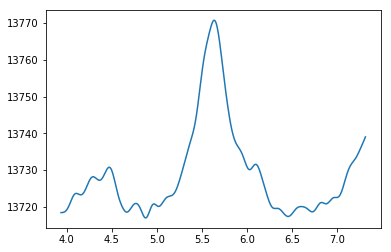

In [73]:
dnugrid = np.linspace(-0.3*np.exp(log_dnu),0.3*np.exp(log_dnu), 500)+np.exp(log_dnu)
like = np.empty_like(dnugrid)
for i,dnu in enumerate(dnugrid):
    k1.set_parameter("log_dnu", np.log(dnu))
    like[i] = gp.log_likelihood(flux)
best = dnugrid[np.argmax(like)]
k1.set_parameter("log_dnu", np.log(best))
plt.plot(dnugrid,like)

      fun: -13774.305958526922
 hess_inv: array([[ 9.58079582e-05, -7.47155441e-06, -4.65841826e-03,
        -4.64092334e-03,  3.27962511e-03,  1.31513722e-03,
        -5.61696725e-05,  2.07593496e-03, -6.32774595e-04,
         1.73631349e-04,  2.30021229e-03,  2.09033330e-04,
        -1.36611889e-05],
       [-7.47155441e-06,  1.91704802e-05,  2.46068223e-04,
         1.91051638e-04, -8.47511724e-04,  1.18514987e-04,
         9.56839401e-05, -2.22168266e-04,  4.33187461e-05,
         4.02571401e-06, -3.52974287e-04, -5.39562821e-05,
        -1.10801914e-05],
       [-4.65841826e-03,  2.46068223e-04,  2.33397168e-01,
         2.30188438e-01, -1.53603439e-01, -6.98202890e-02,
        -2.02017038e-03, -9.86142528e-02,  2.88865669e-02,
        -8.35230997e-03, -1.02992930e-01, -1.85212783e-03,
         9.81917746e-04],
       [-4.64092334e-03,  1.91051638e-04,  2.30188438e-01,
         2.29323538e-01, -1.54116720e-01, -6.77778189e-02,
        -6.00639896e-04, -1.00480209e-01,  2.96562011e

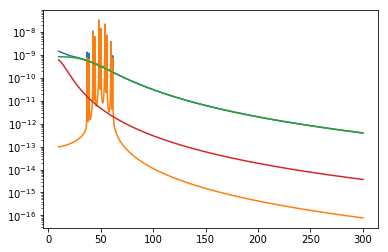

In [74]:
k1.thaw_all_parameters()
soln = minimize(nll, gp.get_parameter_vector())
gp.set_parameter_vector(soln.x)
print(soln)

plt.semilogy(freq_muHz, kernel.get_psd(2*np.pi*freq_muHz))
for term in kernel.terms:
    plt.semilogy(freq_muHz, term.get_psd(2*np.pi*freq_muHz))

In [75]:
from astropy.stats import LombScargle

model = LombScargle(time, flux)
power = model.power(freq_muHz)

(3e-05, 0.1)

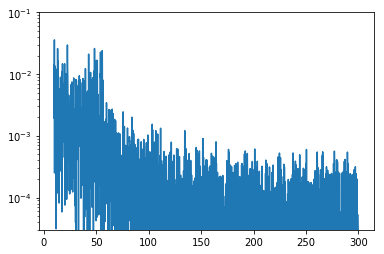

In [76]:
plt.semilogy(freq_muHz, power)
plt.ylim(3e-5,1e-1)

In [77]:
gp.get_parameter_dict()

OrderedDict([('kernel:terms[0]:log_numax', 3.9138889655202767),
             ('kernel:terms[0]:log_dnu', 1.7280837773893194),
             ('kernel:terms[0]:gamma_0', -1.5967336503523064),
             ('kernel:terms[0]:gamma_1', -2.635029737048685),
             ('kernel:terms[0]:log_H0', -16.75593571624376),
             ('kernel:terms[0]:log_H1', -17.608722941823693),
             ('kernel:terms[0]:log_sigma', 1.5165388831252489),
             ('kernel:terms[0]:log_Q', 7.06334560336392),
             ('kernel:terms[1]:log_S0', -20.66718470916173),
             ('kernel:terms[1]:log_omega0', 5.622838978322621),
             ('kernel:terms[2]:log_S0', -20.76024763478728),
             ('kernel:terms[2]:log_omega0', 4.4798387738307035),
             ('kernel:terms[3]:log_sigma', -9.102971069798567)])

In [78]:
def lnprob(params):
    gp.set_parameter_vector(params)

    lp = gp.log_prior()
    if not np.isfinite(lp):
        return -np.inf
    elif params[7] > 12.0:# or -5.0 > params[6] > 5.0:
        return -np.inf
    
    ll = gp.log_likelihood(flux)
    if not np.isfinite(ll):
        return -np.inf
    return ll + lp 
        
# Set up the sampler.
import emcee
#import triangleedit
import time


merged_par = gp.get_parameter_vector()

from matplotlib.ticker import MaxNLocator
ndim, nwalkers = len(merged_par), 30
pos = [merged_par *(1+ 1e-3*np.random.randn(ndim)) for i in range(nwalkers)]
sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob)#, pool=pool) 
    
# Time an MCMC step, and estimate length of time to run chain.
t0 = time.time()
sampler.run_mcmc(pos, 1, rstate0=np.random.get_state())
tstep = time.time()-t0
Nsteps = 1000
from time import localtime, strftime
tstart = strftime("%a, %d %b %Y %H:%M:%S", localtime())
print("""MCMC step runtime (in seconds): {0}
        MCMC estimated total runtime (in seconds): {1}
        Start time: {2}
        """.format(tstep, tstep * Nsteps, tstart))

# Clear and run the production chain.
print("Running MCMC...")
sampler.run_mcmc(pos, Nsteps, rstate0=np.random.get_state())
print("Done.")
print("End time:", strftime("%a, %d %b %Y %H:%M:%S", localtime()))

burnin = 300

MCMC step runtime (in seconds): 0.186906099319458
        MCMC estimated total runtime (in seconds): 186.906099319458
        Start time: Thu, 22 Mar 2018 14:48:47
        
Running MCMC...
Done.
End time: Thu, 22 Mar 2018 14:50:15


In [129]:
best_pars_so_far = sampler.flatchain[np.argmax(sampler.flatlnprobability)]

pos = [best_pars_so_far *(1+ 1e-3*np.random.randn(ndim)) for i in range(nwalkers)]
sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob, pool=pool) 
    
# Time an MCMC step, and estimate length of time to run chain.
t0 = time.time()
sampler.run_mcmc(pos, 1, rstate0=np.random.get_state())
tstep = time.time()-t0
Nsteps = 3000
from time import localtime, strftime
tstart = strftime("%a, %d %b %Y %H:%M:%S", localtime())
print("""MCMC step runtime (in seconds): {0}
        MCMC estimated total runtime (in seconds): {1}
        Start time: {2}
        """.format(tstep, tstep * Nsteps, tstart))

# Clear and run the production chain.
print("Running MCMC with best pars so far...")
sampler.run_mcmc(pos, Nsteps, rstate0=np.random.get_state())
print("Done.")
print("End time:", strftime("%a, %d %b %Y %H:%M:%S", localtime()))

burnin = 300

/Users/samuelgrunblatt/anaconda3/lib/python3.6/site-packages/emcee/ensemble.py:335: RuntimeWarning: invalid value encountered in subtract
  lnpdiff = (self.dim - 1.) * np.log(zz) + newlnprob - lnprob0
/Users/samuelgrunblatt/anaconda3/lib/python3.6/site-packages/emcee/ensemble.py:336: RuntimeWarning: invalid value encountered in greater
  accept = (lnpdiff > np.log(self._random.rand(len(lnpdiff))))


MCMC step runtime (in seconds): 0.05088305473327637
        MCMC estimated total runtime (in seconds): 152.6491641998291
        Start time: Tue, 06 Mar 2018 17:12:55
        
Running MCMC with best pars so far...
Done.
End time: Tue, 06 Mar 2018 17:14:02


In [130]:
best_pars_so_far = sampler.flatchain[np.argmax(sampler.flatlnprobability)]

pos = [best_pars_so_far *(1+ 1e-3*np.random.randn(ndim)) for i in range(nwalkers)]
sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob, pool=pool) 
    
# Time an MCMC step, and estimate length of time to run chain.
t0 = time.time()
sampler.run_mcmc(pos, 1, rstate0=np.random.get_state())
tstep = time.time()-t0
Nsteps = 30000
from time import localtime, strftime
tstart = strftime("%a, %d %b %Y %H:%M:%S", localtime())
print("""MCMC step runtime (in seconds): {0}
        MCMC estimated total runtime (in seconds): {1}
        Start time: {2}
        """.format(tstep, tstep * Nsteps, tstart))

# Clear and run the production chain.
print("Running MCMC with best pars so far...")
sampler.run_mcmc(pos, Nsteps, rstate0=np.random.get_state())
print("Done.")
print("End time:", strftime("%a, %d %b %Y %H:%M:%S", localtime()))

burnin = 3000

/Users/samuelgrunblatt/anaconda3/lib/python3.6/site-packages/emcee/ensemble.py:335: RuntimeWarning: invalid value encountered in subtract
  lnpdiff = (self.dim - 1.) * np.log(zz) + newlnprob - lnprob0
/Users/samuelgrunblatt/anaconda3/lib/python3.6/site-packages/emcee/ensemble.py:336: RuntimeWarning: invalid value encountered in greater
  accept = (lnpdiff > np.log(self._random.rand(len(lnpdiff))))


MCMC step runtime (in seconds): 0.046350955963134766
        MCMC estimated total runtime (in seconds): 1390.528678894043
        Start time: Tue, 06 Mar 2018 17:14:05
        
Running MCMC with best pars so far...
Done.
End time: Tue, 06 Mar 2018 17:24:47


In [81]:
samples = sampler.chain[:, burnin:, :].reshape((-1, ndim))

[log_numax_mcmc, log_dnu_mcmc, gamma0_mcmc, gamma1_mcmc, log_H0_mcmc, \
    log_H1_mcmc, log_sigma_mcmc, log_Q0_mcmc, log_S00_mcmc, log_omega00_mcmc, log_S01_mcmc, log_omega01_mcmc, log_jit] = map(lambda v: (v[1], v[2], v[0]),
                            zip(*np.percentile(samples, [16, 50, 84], axis=0))) 
print("""MCMC result:
numax = {0[0]} upper{0[1]} lower{0[2]} 
dnu = {1[0]} +{1[1]} -{1[2]}
gamma0 = {2[0]} +{2[1]} -{2[2]} 
gamma1 = {3[0]} +{3[1]} -{3[2]}
log_H0 = {4[0]} +{4[1]} -{4[2]} 
log_H1 = {5[0]} +{5[1]} -{5[2]}
log_sigma = {6[0]} +{6[1]} -{6[2]}
log_Q0 = {7[0]} +{7[1]} -{7[2]} 
log_S0,0 = {8[0]} +{8[1]} -{8[2]}
log_omega0,0 = {9[0]} +{9[1]} -{9[2]}
log_S0,1 = {10[0]} +{10[1]} -{10[2]}
log_omega0,1 = {11[0]} +{11[1]} -{11[2]}
log_whitenoise = {12[0]} +{12[1]} -{12[2]}
""".format(np.exp(log_numax_mcmc), np.exp(log_dnu_mcmc), gamma0_mcmc, gamma1_mcmc, log_H0_mcmc, \
    log_H1_mcmc, log_sigma_mcmc, log_Q0_mcmc, log_S00_mcmc, log_omega00_mcmc, log_S01_mcmc, log_omega01_mcmc, log_jit)) 
#lnper = {8[0]} +{8[1]} -{8[2]} 

print("Mean acceptance fraction: {0:.3f}"
        .format(np.mean(sampler.acceptance_fraction)))

MCMC result:
numax = 50.13576444403293 upper51.010328311768404 lower49.08690350015256 
dnu = 5.615181651121452 +5.651517897940968 -5.567895406077133
gamma0 = -1.5953836999399693 +-0.598736838659179 --2.383501289172233 
gamma1 = -2.6103103450831573 +-1.5731352368464244 --3.3853181571491806
log_H0 = -17.017609280455197 +-15.731566071346855 --18.10440179313975 
log_H1 = -17.826502121466095 +-16.79759183413222 --18.700163851423667
log_sigma = 1.5366310507126564 +1.8077119959347603 -1.3307991358583608
log_Q0 = 6.83678582562208 +7.589668925309908 -5.979715588342318 
log_S0,0 = -20.609591970102592 +-20.393050686501994 --20.897202803772192
log_omega0,0 = 5.605632669979883 +5.681005561229738 -5.539799076621312
log_S0,1 = -20.96849796286272 +-20.52589267404378 --21.840568112055806
log_omega0,1 = 4.549573700036597 +4.9544359461936525 -4.197845553539581
log_whitenoise = -9.102426853328582 +-9.065994588799585 --9.137209135238066

Mean acceptance fraction: 0.334


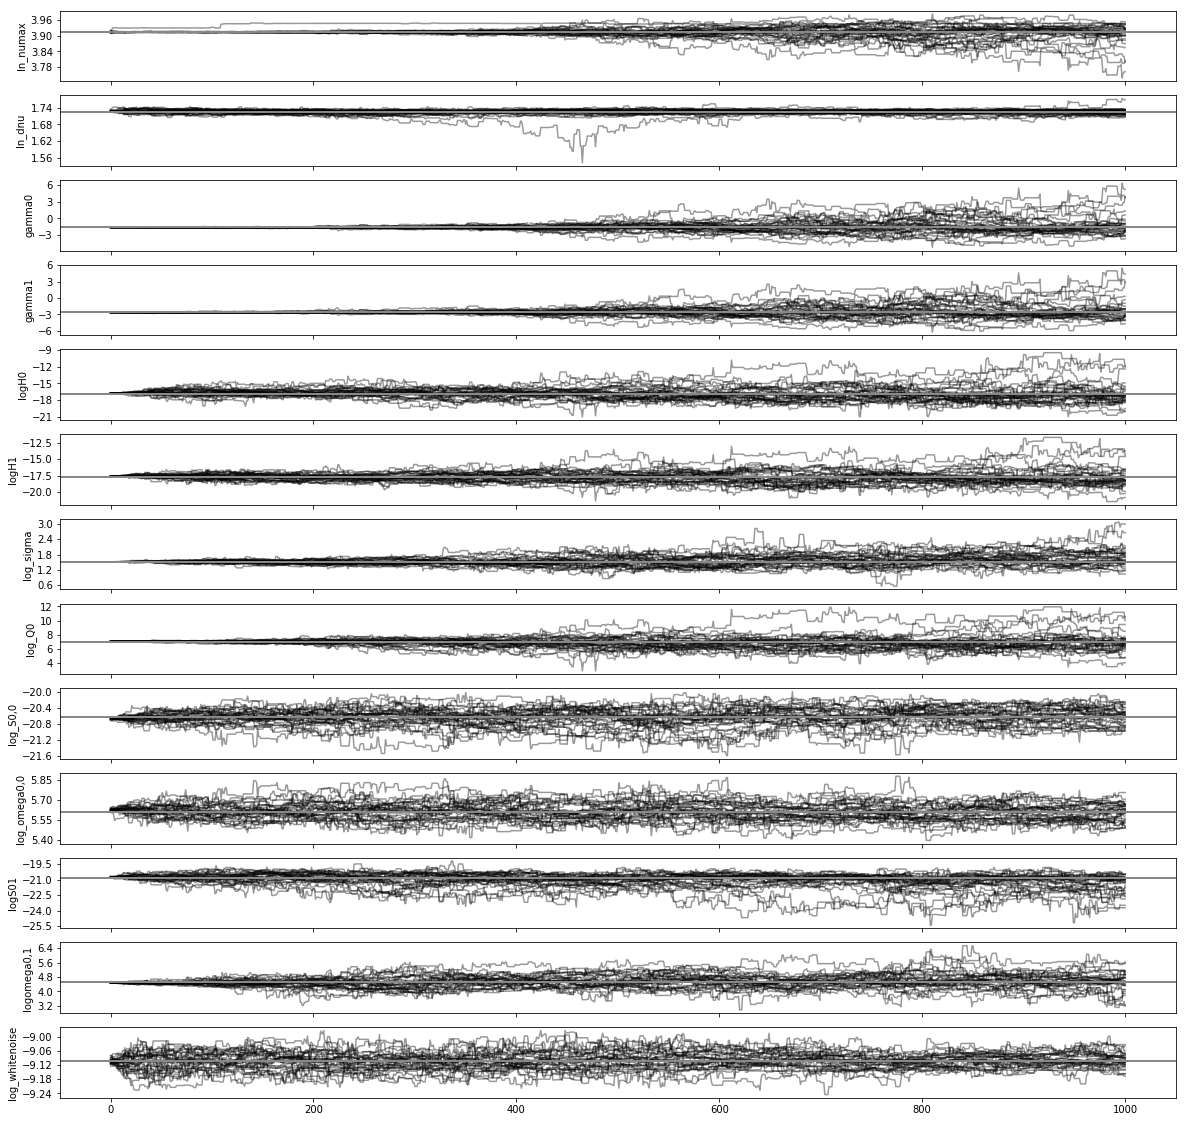

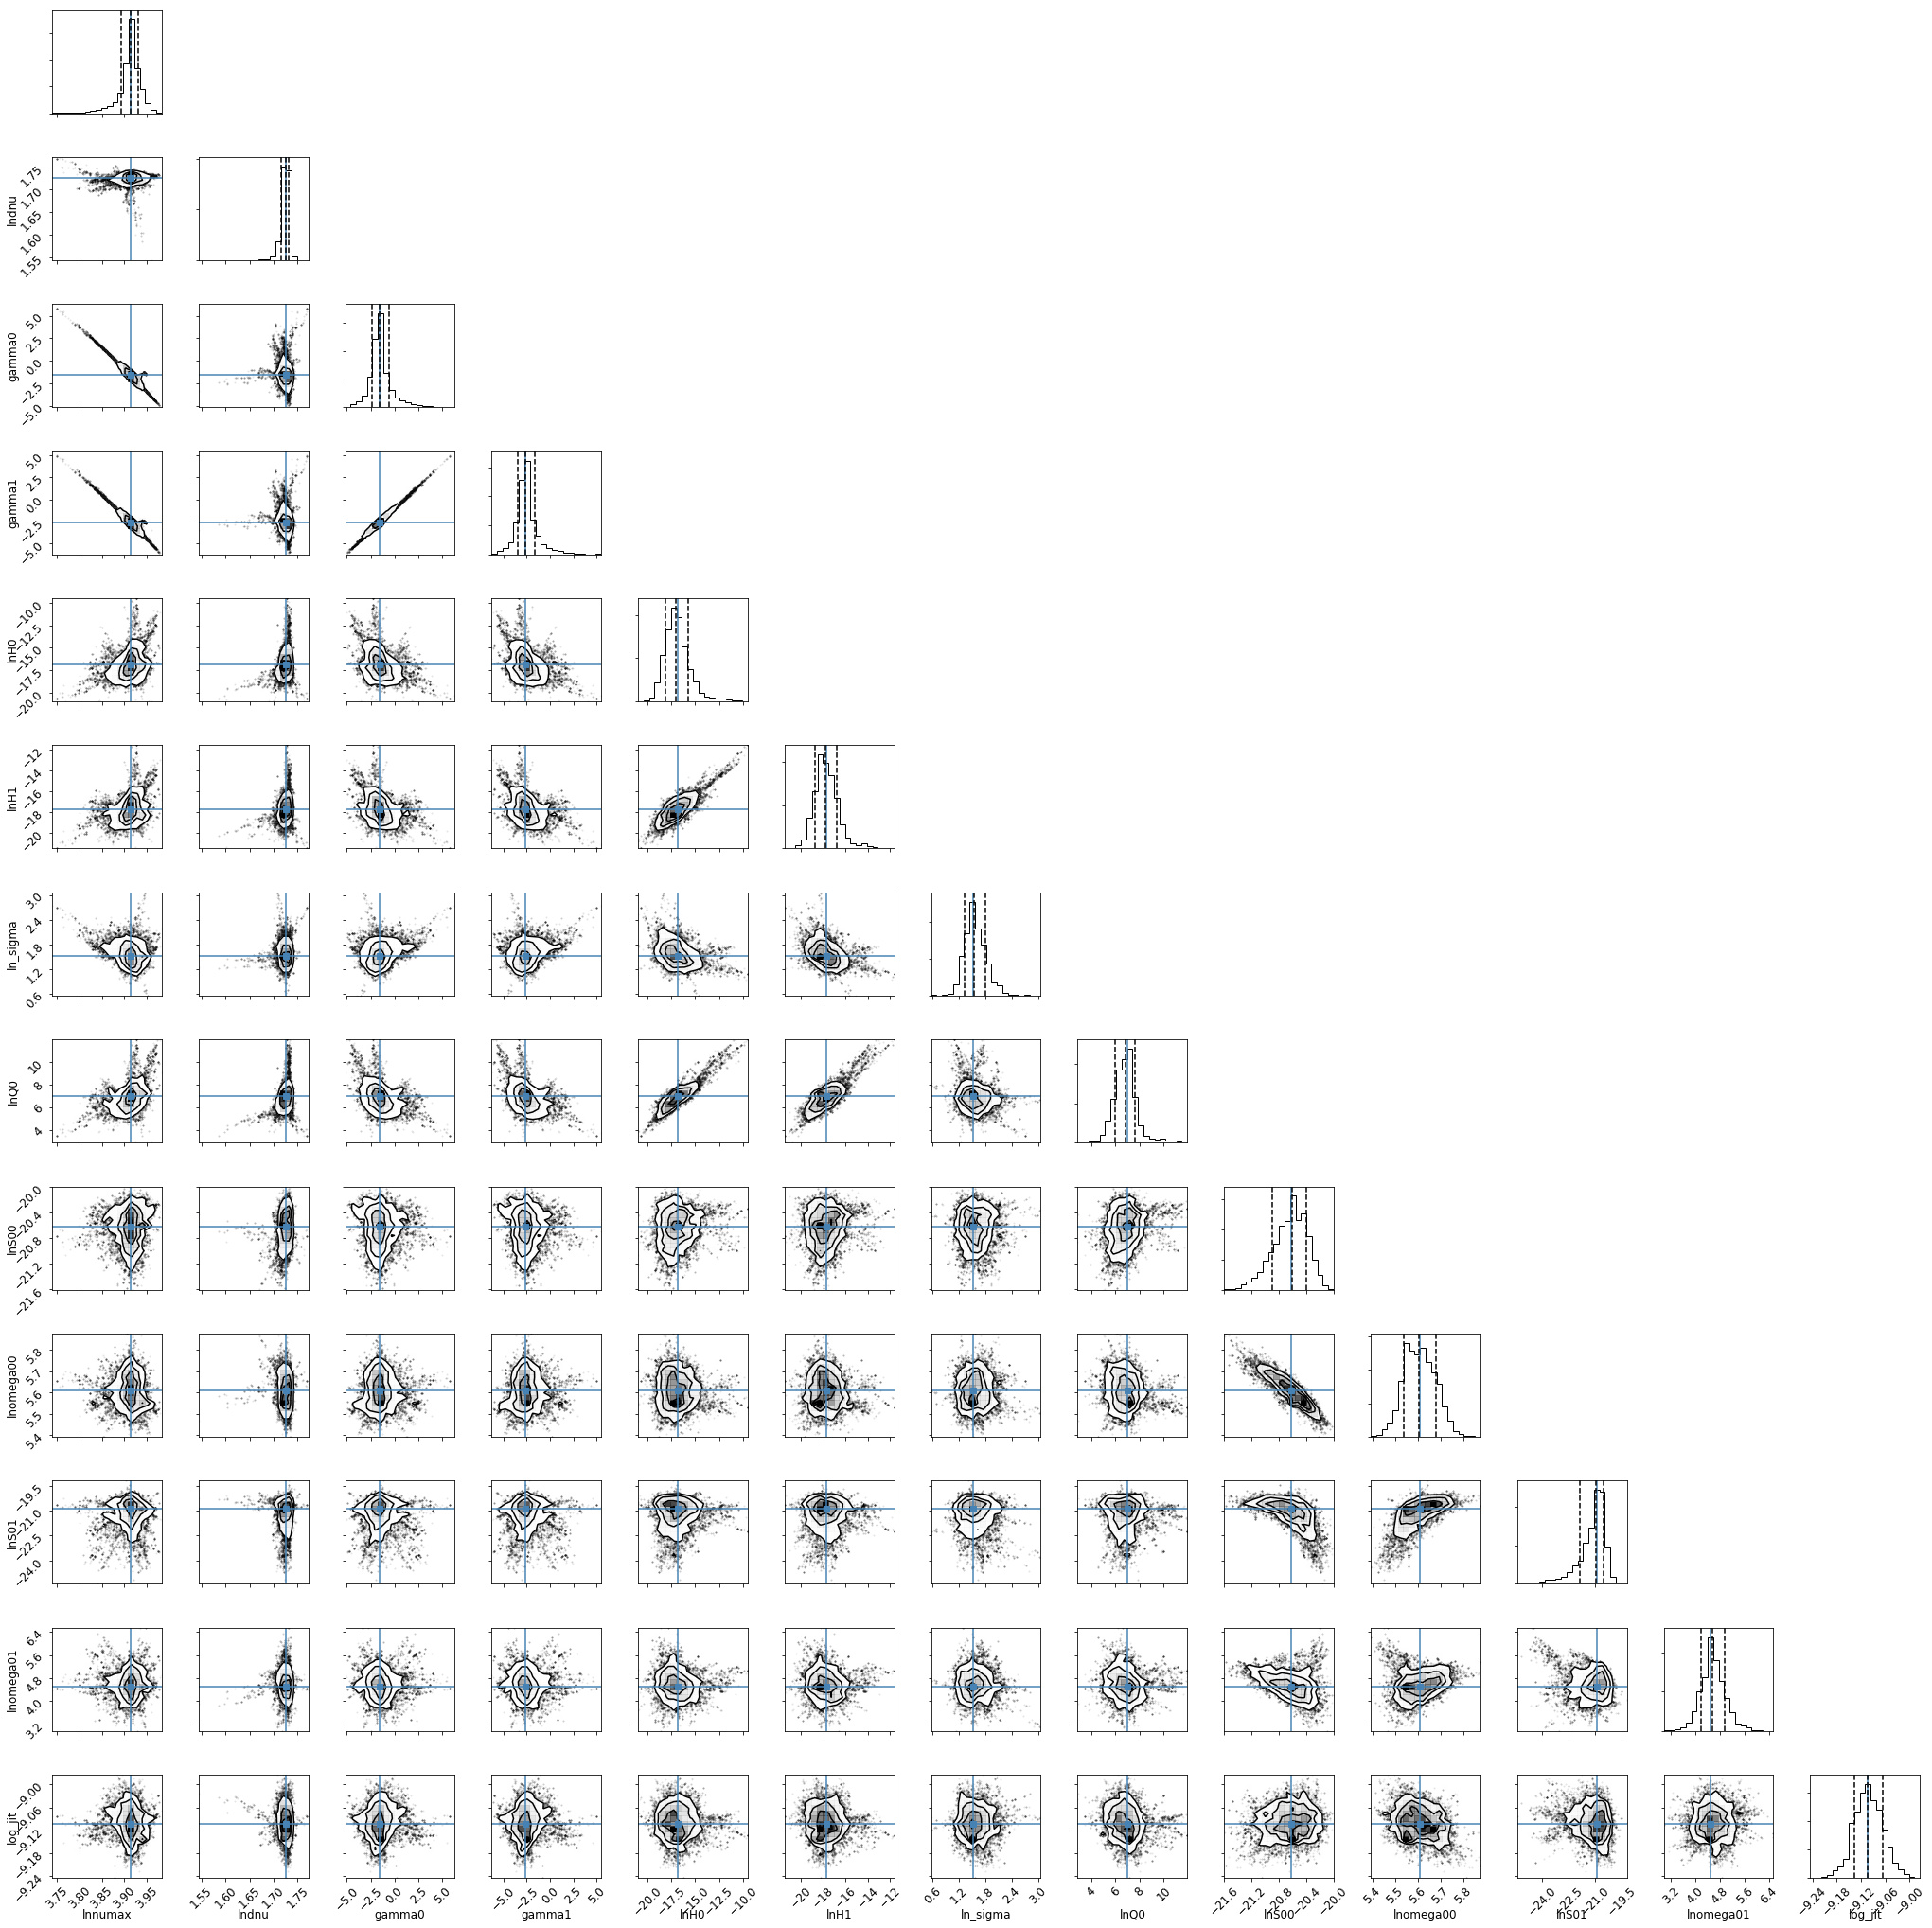

In [80]:
plt.clf()
fig, axes = plt.subplots(len(merged_par), 1, sharex=True, figsize=(20, 20))
axes[0].plot((sampler.chain[:, :, 0].T), color="k", alpha=0.4)
axes[0].yaxis.set_major_locator(MaxNLocator(5))
axes[0].axhline(np.median(sampler.chain[:, :, 0].T), color="#888888", lw=2)
axes[0].set_ylabel(r"ln_numax")
    
axes[1].plot((sampler.chain[:, :, 1].T), color="k", alpha=0.4)
axes[1].yaxis.set_major_locator(MaxNLocator(5))
axes[1].axhline(np.median(sampler.chain[:, :, 1].T), color="#888888", lw=2)
axes[1].set_ylabel(r"ln_dnu")

axes[2].plot((sampler.chain[:, :, 2].T), color="k", alpha=0.4)
axes[2].yaxis.set_major_locator(MaxNLocator(5))
axes[2].axhline(np.median(sampler.chain[:, :, 2].T), color="#888888", lw=2)
axes[2].set_ylabel(r"gamma0")
    
axes[3].plot((sampler.chain[:, :, 3].T), color="k", alpha=0.4)
axes[3].yaxis.set_major_locator(MaxNLocator(5))
axes[3].axhline(np.median(sampler.chain[:, :, 3].T), color="#888888", lw=2)
axes[3].set_ylabel(r"gamma1")

axes[4].plot((sampler.chain[:, :, 4].T), color="k", alpha=0.4)
axes[4].yaxis.set_major_locator(MaxNLocator(5))
axes[4].axhline(np.median(sampler.chain[:, :, 4].T), color="#888888", lw=2)
axes[4].set_ylabel(r"logH0")

axes[5].plot((sampler.chain[:, :, 5].T), color="k", alpha=0.4)
axes[5].yaxis.set_major_locator(MaxNLocator(5))
axes[5].axhline(np.median(sampler.chain[:, :, 5].T), color="#888888", lw=2)
axes[5].set_ylabel(r"logH1")

axes[6].plot((sampler.chain[:, :, 6].T), color="k", alpha=0.4)
axes[6].yaxis.set_major_locator(MaxNLocator(5))
axes[6].axhline(np.median(sampler.chain[:, :, 6].T), color="#888888", lw=2)
axes[6].set_ylabel(r"log_sigma")

axes[7].plot((sampler.chain[:, :, 7].T), color="k", alpha=0.4)
axes[7].yaxis.set_major_locator(MaxNLocator(5))
axes[7].axhline(np.median(sampler.chain[:, :, 7].T), color="#888888", lw=2)
axes[7].set_ylabel(r"log_Q0")

axes[8].plot((sampler.chain[:, :, 8].T), color="k", alpha=0.4)
axes[8].yaxis.set_major_locator(MaxNLocator(5))
axes[8].axhline(np.median(sampler.chain[:, :, 8].T), color="#888888", lw=2)
axes[8].set_ylabel(r"log_S0,0")

axes[9].plot((sampler.chain[:, :, 9].T), color="k", alpha=0.4)
axes[9].yaxis.set_major_locator(MaxNLocator(5))
axes[9].axhline(np.median(sampler.chain[:, :, 9].T), color="#888888", lw=2)
axes[9].set_ylabel(r"log_omega0,0")

axes[10].plot((sampler.chain[:, :, 10].T), color="k", alpha=0.4)
axes[10].yaxis.set_major_locator(MaxNLocator(5))
axes[10].axhline(np.median(sampler.chain[:, :, 10].T), color="#888888", lw=2)
axes[10].set_ylabel(r"logS01")

axes[11].plot((sampler.chain[:, :, 11].T), color="k", alpha=0.4)
axes[11].yaxis.set_major_locator(MaxNLocator(5))
axes[11].axhline(np.median(sampler.chain[:, :, 11].T), color="#888888", lw=2)
axes[11].set_ylabel(r"logomega0,1")

axes[12].plot((sampler.chain[:, :, 12].T), color="k", alpha=0.4)
axes[12].yaxis.set_major_locator(MaxNLocator(5))
axes[12].axhline(np.median(sampler.chain[:, :, 12].T), color="#888888", lw=2)
axes[12].set_ylabel(r"log_whitenoise")


import corner
from matplotlib.ticker import MultipleLocator, FormatStrFormatter


majorFormatter = FormatStrFormatter('%.2f')
fig, ax = plt.subplots()
ax.xaxis.set_major_formatter(majorFormatter)

plt.clf()
plt.rcParams["font.size"] = 12
#plt.rcParams["font.family"] = "sans-serif"
#plt.rcParams["font.sans-serif"] = ["Computer Modern Sans"]
#plt.rcParams["text.usetex"] = True
#plt. rcParams["text.latex.preamble"] = r"\usepackage{cmbright}"
#plt.rcParams['font.size']=18  
fig = corner.corner(samples, labels=[r"lnnumax", r"lndnu", r"gamma0", r"gamma1", r"lnH0", r"lnH1", r"ln_sigma",\
                                     r"lnQ0", r"lnS00", r"lnomega00", r"lnS01", r"lnomega01", "log_jit"], quantiles=[0.16, 0.5, 0.84],
                      truths=[np.median(sampler.chain[:, :, 0].T), np.median(sampler.chain[:, :, 1].T), np.median(sampler.chain[:, :, 2].T), \
                              np.median(sampler.chain[:, :, 3].T), np.median(sampler.chain[:, :, 4].T), np.median(sampler.chain[:, :, 5].T), \
                              np.median(sampler.chain[:, :, 6].T), np.median(sampler.chain[:, :, 7].T), np.median(sampler.chain[:, :, 8].T), \
                              np.median(sampler.chain[:, :, 9].T), np.median(sampler.chain[:, :, 10].T), np.median(sampler.chain[:, :, 11].T), \
                              np.median(sampler.chain[:, :, 12].T)])
    
fig.tight_layout()
